In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML100k'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-latest-small'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat]=\
    pickle.load(open(f'{DATAPATH}/df_side_cold_runother_cf.pkl','rb'))

In [4]:
dftrain.columns

Index(['index', 'flag_train', 'genres', 'imdbId', 'itemId', 'maxSeqNum',
       'rating', 'seqNum', 'tag', 'timestamp',
       ...
       'f_tag_the', 'f_tag_to', 'f_tag_trek', 'f_tag_wars', 'f_tag_who',
       'f_tag_with', 'f_tag_world', 'f_tag_you', 'user_idx', 'item_idx'],
      dtype='object', length=391)

In [5]:
denseCols=dftrain.columns[dftrain.columns.str.startswith('f_')].tolist()

In [6]:
denseCols

['f_title_12',
 'f_title_13',
 'f_title_1940',
 'f_title_1954',
 'f_title_1959',
 'f_title_1960',
 'f_title_1962',
 'f_title_1963',
 'f_title_1964',
 'f_title_1967',
 'f_title_1968',
 'f_title_1970',
 'f_title_1971',
 'f_title_1972',
 'f_title_1973',
 'f_title_1974',
 'f_title_1975',
 'f_title_1976',
 'f_title_1977',
 'f_title_1978',
 'f_title_1979',
 'f_title_1980',
 'f_title_1981',
 'f_title_1982',
 'f_title_1983',
 'f_title_1984',
 'f_title_1985',
 'f_title_1986',
 'f_title_1987',
 'f_title_1988',
 'f_title_1989',
 'f_title_1990',
 'f_title_1991',
 'f_title_1992',
 'f_title_1993',
 'f_title_1994',
 'f_title_1995',
 'f_title_1996',
 'f_title_1997',
 'f_title_1998',
 'f_title_1999',
 'f_title_2000',
 'f_title_2001',
 'f_title_2002',
 'f_title_2003',
 'f_title_2004',
 'f_title_2005',
 'f_title_2006',
 'f_title_2007',
 'f_title_2008',
 'f_title_2009',
 'f_title_2010',
 'f_title_2011',
 'f_title_2012',
 'f_title_2013',
 'f_title_2014',
 'f_title_2015',
 'f_title_2016',
 'f_title_2017',
 

### Dataset and DataLoader

In [7]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY,denseCols):
        self.dfX,self.dfY=dfX,dfY
        self.denseCols=denseCols
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.FloatTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [8]:
dstrain=cfdata(dftrain[['user_idx','item_idx']+denseCols],dftrain['rating'],denseCols)
dsvalid=cfdata(dfvalid[['user_idx','item_idx']+denseCols],dfvalid['rating'],denseCols)

In [9]:
dftrain.shape

(90543, 391)

In [10]:
bs=64

In [11]:
dltrain=DataLoader(dstrain,bs,True)

In [12]:
dlvalid=DataLoader(dsvalid,bs,False)

## Model Architecture

In [13]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=25
n_emb_item=25
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05
hidden=[20,25,10]
dropouts=[0.2,0.3,0.2]

In [14]:
def hidden_layer(x,y,dropout,activation=nn.Sigmoid()):
    return nn.Sequential(
        nn.Linear(x, y),
        activation,
        nn.Dropout(p=dropout)
        )   

In [15]:
#[mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb]=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
#pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))
pretrain_wts=None

In [16]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,autoenc_cols,pretrain_wts,\
                 dropout_e=0.01,hidden=[15,5],dropouts=[0.2,0.2],error_type="mse"):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e,self.hidden,self.dropouts=dropout_e,hidden,dropouts
        self.autoenc_cols,self.len_dense_cols=autoenc_cols,len(autoenc_cols)
        self.create_architecture()
        self.init_parameters()
        
        if pretrain_wts is not None:
            self.emb_user.weight.data=torch.FloatTensor(pretrain_wts[0])
            self.emb_item.weight.data=torch.FloatTensor(pretrain_wts[1])
            self.ub.weight.data=torch.FloatTensor(pretrain_wts[2])
            self.ib.weight.data=torch.FloatTensor(pretrain_wts[3])

        if error_type!="mse":
            self.criterion=nn.L1Loss()
        else:
            self.criterion=nn.MSELoss()
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)
        
        
        self.emb_dropout=nn.Dropout(self.dropout_e)

        
        self.lin1= nn.Sequential(nn.Linear(self.n_emb_user+self.n_emb_item,self.hidden[0]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[0]) )
        self.lin_bias=nn.Linear(3,1)
        self.lin2= nn.Sequential (nn.Linear(self.len_dense_cols,self.hidden[1]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[1]) )
        self.lin3= nn.Sequential (nn.Linear(self.hidden[0]+self.hidden[1]+1,self.hidden[2]),
                    nn.ReLU(),
                    nn.Dropout(p=dropouts[2]))
        self.lin4=nn.Linear(self.hidden[2],1)
        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.zeros_(self.ub.weight.data)
        nn.init.zeros_(self.ib.weight.data)
        nn.init.kaiming_normal_(self.lin1[0].weight.data)
        nn.init.kaiming_normal_(self.lin2[0].weight.data)
        nn.init.kaiming_normal_(self.lin3[0].weight.data)
        #nn.init.kaiming_normal_(lin)
       
    def forward (self,Xb,Yb):
        users=Xb[:,0].long()
        items=Xb[:,1].long()
        users=self.emb_dropout(self.emb_user(users))
        items=self.emb_dropout(self.emb_item(items))
        users_bias=self.emb_dropout(self.ub(Xb[:,0].long()))
        items_bias=self.emb_dropout(self.ib(Xb[:,1].long()))
        embed=torch.cat([users,items],1)
        out1=self.lin1(embed)
        bias=torch.cat([users_bias,items_bias,users_bias+items_bias],1)
        biased=self.lin_bias(bias)
           
        
        denses=Xb[:,2:]
        out2=self.lin2(denses)
        
        out3=torch.cat([out1,out2,biased],1)
        
        out4=self.lin3(out3)
        
        out5=self.lin4(out4)
        
        out=self.sigmoid(out5)
        
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        #preds=preds.view(-1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [17]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [18]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=374, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [19]:
for Xb, Yb in dltrain:
    break

In [20]:
Xb.shape, Yb.shape

(torch.Size([64, 376]), torch.Size([64, 1]))

In [21]:
Xb.dtype

torch.float32

In [22]:
cfobj.forward(Xb,Yb)

(tensor([[2.5293],
         [2.6946],
         [2.8198],
         [2.6386],
         [2.9241],
         [2.6748],
         [2.5284],
         [2.7544],
         [2.6914],
         [2.6513],
         [2.8092],
         [2.8554],
         [2.7532],
         [2.8268],
         [2.7686],
         [2.9575],
         [2.7291],
         [2.9499],
         [2.8868],
         [2.7680],
         [2.9320],
         [2.4244],
         [2.8178],
         [2.9152],
         [2.5337],
         [2.7547],
         [2.8406],
         [2.6963],
         [2.8857],
         [2.9221],
         [2.8414],
         [2.7755],
         [2.8502],
         [2.7406],
         [2.3537],
         [2.9020],
         [2.6792],
         [2.5256],
         [2.9563],
         [2.8487],
         [2.6657],
         [3.2429],
         [2.8593],
         [2.5506],
         [2.8493],
         [2.9543],
         [2.8766],
         [2.6972],
         [2.7322],
         [2.7795],
         [2.8214],
         [2.7479],
         [2.

## Learner

In [23]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [24]:
device='cuda:0'

In [25]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")

In [26]:
cfobj=cfobj.to(device)

In [27]:
cfobj

cf(
  (emb_user): Embedding(611, 25)
  (emb_item): Embedding(9725, 25)
  (ub): Embedding(611, 1)
  (ib): Embedding(9725, 1)
  (emb_dropout): Dropout(p=0.05)
  (lin1): Sequential(
    (0): Linear(in_features=50, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin_bias): Linear(in_features=3, out_features=1, bias=True)
  (lin2): Sequential(
    (0): Linear(in_features=374, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3)
  )
  (lin3): Sequential(
    (0): Linear(in_features=46, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
  )
  (lin4): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [34]:
wd=1e-7
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=0)

In [35]:
len(dltrain)

354

In [36]:
learner.lr_find(1e-4,1e-1,dltrain,len(dltrain))

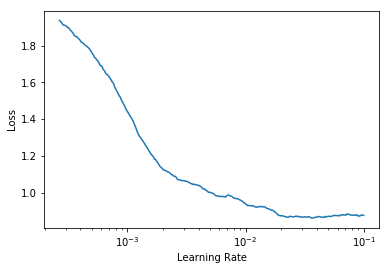

In [37]:
learner.plot_lrs(50)

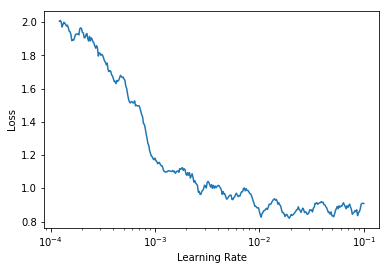

In [38]:
learner.plot_lrs(10)

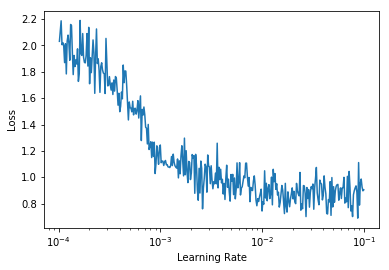

In [39]:
learner.plot_lrs(1)

In [54]:
del cfobj
torch.cuda.empty_cache()

In [55]:
pretrain_wts=pickle.load(open(f'{DATAPATH}/wts_embs','rb'))

In [56]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,denseCols,pretrain_wts,dropout_e,hidden,dropouts,error_type="mse")
cfobj=cfobj.to(device)

In [57]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=False
    cfobj.emb_item.weight.requires_grad=False
    cfobj.ib.weight.requires_grad=False
    cfobj.ub.weight.requires_grad=False

In [58]:
wd=5e-4
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=2e-4,wd_mult=1.15)

In [59]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 0.0005 Train Loss:0.6798968412429621                 Valid Loss:0.7417301141327213 Train RMSE:0.8179276490728125 Valid RMSE:0.8443931009855867 Train MSE:0.6798968412429621 Valid MSE:0.7417301141327213                 Train MAE:0.6372389010532163 Valid MAE:0.6653075468095934
Epoch:1 Learning rate 0.001 Weight Decay 0.000575 Train Loss:0.5828073922399919                 Valid Loss:0.7499631708082946 Train RMSE:0.7591005679056269 Valid RMSE:0.8500328287666937 Train MSE:0.5828073922399919 Valid MSE:0.7499631708082946                 Train MAE:0.5893432912051467 Valid MAE:0.6687286668312475
Epoch:2 Learning rate 0.0002 Weight Decay 0.0006612499999999999 Train Loss:0.5707652142317472                 Valid Loss:0.7515662430050951 Train RMSE:0.7512975993335171 Valid RMSE:0.8508915243980248 Train MSE:0.5707652142317472 Valid MSE:0.7515662430050951                 Train MAE:0.5834821259385705 Valid MAE:0.6702238006621414
Epoch:3 Learning rate 0.005 Weight

In [60]:
if 1==1:
    cfobj.emb_user.weight.requires_grad=True
    cfobj.emb_item.weight.requires_grad=True
    cfobj.ib.weight.requires_grad=True
    cfobj.ub.weight.requires_grad=True

In [61]:
if 1==1:
    optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
    learner=Learner(cfobj,optimizer,None,device,0,12000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=2e-4,wd_mult=1.15)
    learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 0.0005 Train Loss:0.7823570048851175                 Valid Loss:0.7815065246005977 Train RMSE:0.8795456096903391 Valid RMSE:0.8666642649368046 Train MSE:0.7823570048851175 Valid MSE:0.7815065246005977                 Train MAE:0.6854503815881776 Valid MAE:0.6849717557060052
Epoch:1 Learning rate 0.001 Weight Decay 0.000575 Train Loss:0.7188673474763392                 Valid Loss:0.7603845569472876 Train RMSE:0.8427754026620019 Valid RMSE:0.8544786545486722 Train MSE:0.7188673474763392 Valid MSE:0.7603845569472876                 Train MAE:0.6525847482386411 Valid MAE:0.6759438768306875
Epoch:2 Learning rate 0.0002 Weight Decay 0.0006612499999999999 Train Loss:0.672627653355312                 Valid Loss:0.7520334162512181 Train RMSE:0.8153847851462215 Valid RMSE:0.8497743479123209 Train MSE:0.672627653355312 Valid MSE:0.7520334162512181                 Train MAE:0.6303547332017245 Valid MAE:0.6706510582325621
Epoch:3 Learning rate 0.005 Weight D

In [62]:
learner.generate_scores=True

In [63]:
learner.run_epoch(dlvalid,False)

(0.7473618601975234, 0.6659142758165087, 0.8474549873732122)

In [64]:
dfvalid['pred_dnnrec']=np.concatenate(learner.scores)

In [65]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_dnnrec']))

0.8641535583319966

In [66]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [67]:
result_dnnrec=pd.concat([score_by_group(dfvalid,'pred_dnnrec','cold_start_group','dnnrec'),score_by_group(dfvalid,'pred_dnnrec','cold_start_bucket','dnnrec'),\
score_by_group(dfvalid,'pred_dnnrec','flag_train','dnnrec')],axis=0)
result_dnnrec

,method,mse,rmse,mae,r2_score,Cold Start Group
0,dnnrec,0.735525,0.857628,0.658446,0.333584,No-cold-start
1,dnnrec,0.841234,0.917188,0.721971,0.348482,Item-Cold_start
2,dnnrec,1.178016,1.085365,0.971160,-0.282710,User-Cold-Start
0,dnnrec,0.735525,0.857628,0.658446,0.333584,0
1,dnnrec,0.873865,0.934807,0.746115,0.364366,1
0,dnnrec,0.746761,0.864154,0.665566,0.338184,0


In [68]:
torch.save(cfobj,f=f'{DATAPATH}/inter/cfobj_tl_0.8')
torch.save(learner,f=f'{DATAPATH}/inter/cfobj_tl_learner_0.8')
torch.save(optimizer,f=f'{DATAPATH}/inter/cfobj_tl_optimizer_0.8')
torch.save(cfobj.state_dict(),f'{DATAPATH}/inter/cfjobj_tl_state_dict_0.8')
torch.save(optimizer.state_dict(),f'{DATAPATH}/inter/optimizer_tl_state_dict_0.8')

/home/kirana/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type cf. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [69]:
results_concat.shape

(66, 6)

In [70]:
results_concat=pd.concat([results_concat,result_dnnrec],axis=0)

In [71]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_dnnrec.pkl','wb'))